# Agarose phantom analysis

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from scipy import ndimage
import cv2
from tqdm import tqdm

## Reading in the images

In [27]:
img_dir = r'D:\MSci_Project\1_Data\2023-03-17'

phantom = io.imread(img_dir + r'\2023-03-17 phase gradient phantom fullstack.tif')
phantom = phantom.reshape((400,4,1392,1040)).astype('float32')

KeyboardInterrupt: 

In [ ]:
im_width = 1040
im_height = 1392

Reshape into dimensions
* 400 (projections)
* 4 (illuminations)
* 1392 (height)
* 1040 (width)

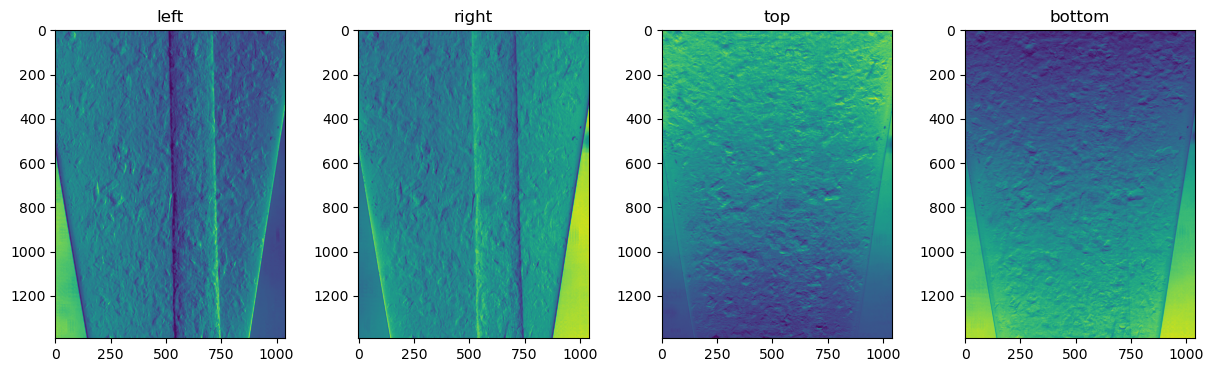

In [ ]:
title_labels = ['left','right', 'top', 'bottom']
fig, ax = plt.subplots(1,4 ,figsize=(15, 4))
for i in range(4):
    ax[i].imshow(phantom[4][i])
    ax[i].set_title(title_labels[i])


In [ ]:
background = io.imread(img_dir + r'\2023-03-17 phase gradient background.tif').astype('float32')[0:]

def get_averaged_stack(im_stack, num_repeats):
    # Gets averaged image stack, assuming shape of image stack is (num_repeats * z_stack_depth, im_height, im_width)
    # num_repeats (int): number of averaged images
    # SIMILAR TO calibrations/lens_aperture.ipynb, but order is reversed
    num_repeats = int(num_repeats)

    dim_0, im_length, im_width = im_stack.shape
    reshaped = im_stack.reshape(num_repeats, dim_0//num_repeats, im_length, im_width)
    output = np.mean(reshaped, axis=0)
    return output

background = get_averaged_stack(background, 5)
# np.max(background[4])
# plt.imshow(background.reshape(5,4, 1392, 1040)[2,0,:,:])

Background
* Important to see that it is working correctly

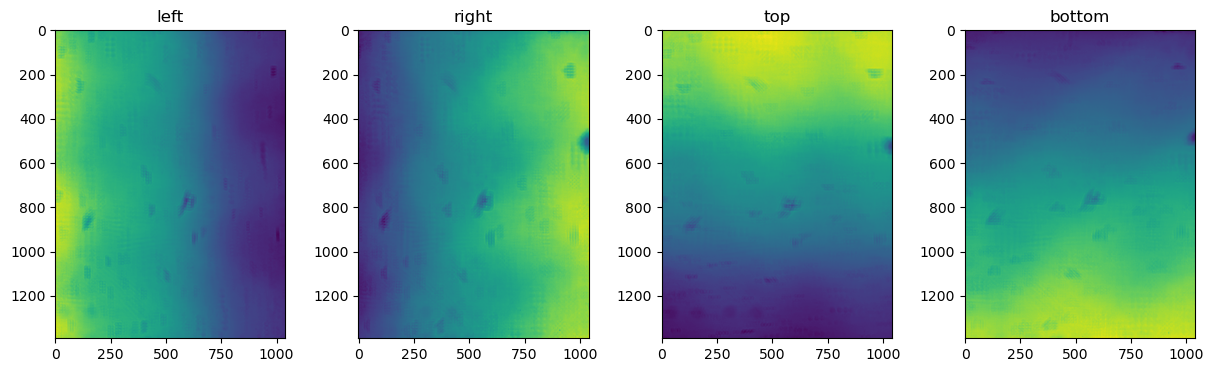

In [ ]:
title_labels = ['left','right', 'top', 'bottom']
fig, ax = plt.subplots(1,4 ,figsize=(15, 4))
for i in range(4):
    ax[i].imshow(background[i])
    ax[i].set_title(title_labels[i])

In [ ]:
phantom -= background

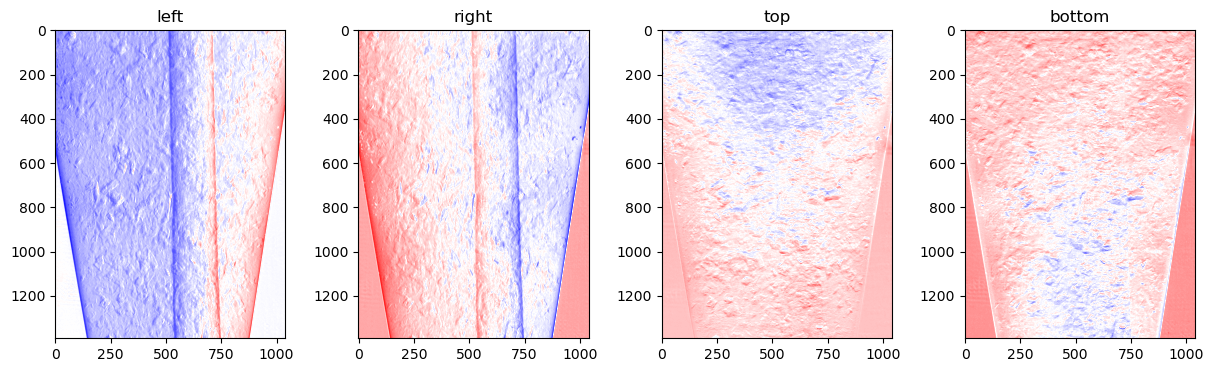

In [ ]:
title_labels = ['left','right', 'top', 'bottom']
fig, ax = plt.subplots(1,4 ,figsize=(15, 4))
for i in range(4):
    ax[i].imshow(phantom[4][i], cmap='bwr')
    ax[i].set_title(title_labels[i])

In [ ]:
phantom.shape, background.shape

((400, 4, 1392, 1040), (4, 1392, 1040))

In [ ]:
left_right = phantom[:,1,:,:] - phantom[:,0,:,:]
top_bottom = phantom[:,2,:,:] - phantom[:,3,:,:]

## Phase gradient

Use the indexing above to generate the illumination images, then pass into `plot_phase_gradient` to perform the necessary subtraction and integration. Optionally plot a row for debugging. 

Text(0.5, 1.0, 'Top-bottom')

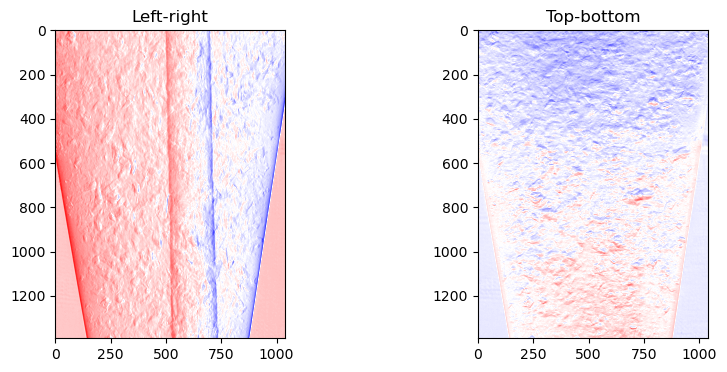

In [ ]:
slice = 0
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(left_right[slice], cmap='bwr')
ax[0].set_title('Left-right')
ax[1].imshow(top_bottom[slice], cmap='bwr')
ax[1].set_title('Top-bottom')

### Attempting 2D Fourier integral method

Simple 1D integration doesn't work, probably because:
- our sample is thicc (so phase probably wraps many times over)
- our sample leaves the field of view (so we have unknown boundary conditions)
- we have low counting statistics (high noise)

So instead we should try the 2D Fourier method:

$$ \Phi (x, y) = \mathcal{F}^{-1} [\frac{\mathcal{F}[\Phi_x + i \Phi_y](k, l)}{2\pi i (k + il)}](x, y) = \mathcal{F}^{-1} [\frac{\mathcal{F}[g](k, l)}{2\pi i (k + il)}](x, y) $$

Source: [A two-directional approach for grating based differential phase contrast imaging using hard X-rays](https://www.researchgate.net/publication/26297519_A_two-directional_approach_for_grating_based_differential_phase_contrast_imaging_using_hard_X-rays)

In [ ]:
phi_x = left_right[0]
phi_y = top_bottom[0]

In [ ]:
def fourier(image):
    # Takes 2D Fourier transform of image
    ft = np.fft.ifftshift(image)
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)
    
    # freq_x = np.fft.fftfreq(ft.shape[0])
    # freq_y = np.fft.fftfreq(ft.shape[1])
    # freq_x = np.fft.fftshift(freq_x)
    # freq_y = np.fft.fftshift(freq_y)

    # plt.imshow(np.abs(ft), extent=(freq_x.min(),freq_x.max(),freq_y.min(),freq_y.max()))
    # plt.colorbar()
    # plt.xlabel('k')
    # plt.ylabel('l')
    # plt.show()
               
    return ft# , (freq_x, freq_y)

def inv_fourier(ft):
    # Takes 2D inverse FT of image
    ift = np.fft.ifftshift(ft)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)

    return ift

def do_fourier_integration(dphi_x, dphi_y, freq_x, freq_y):
    # small epsilon to prevent division by 0
    eps = 5e-16
    # integrate g
    g = dphi_x + (1j * dphi_y)
    ft_g = fourier(g)
    # denominator of the fraction
    freq_xx, freq_yy = np.meshgrid(freq_x, freq_y, indexing='ij')
    denom = ((2. * np.pi * 1.0j) * (freq_xx + (1.0j * freq_yy))) + eps
    phi = inv_fourier(ft_g / denom)
    return np.imag(phi)

In [ ]:
freq_x = np.fft.fftfreq(im_height)
freq_y = np.fft.fftfreq(im_width)
freq_x = np.fft.fftshift(freq_x)
freq_y = np.fft.fftshift(freq_y)

initial = do_fourier_integration(left_right[0], top_bottom[0], freq_x, freq_y)
phi = (initial- np.min(initial))/np.max(initial) *65535

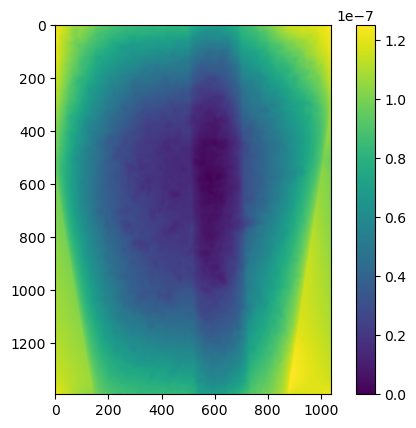

In [ ]:
plt.imshow(phi, cmap='viridis')
plt.colorbar()

Now altogether

In [ ]:
num_projections = 400
phase_contrast = np.zeros((num_projections, im_height, im_width))

for i in tqdm(range(num_projections)):
    phi = do_fourier_integration(left_right[i], top_bottom[i], freq_x, freq_y)
    phase_contrast[i] = phi

100%|██████████| 400/400 [02:16<00:00,  2.93it/s]


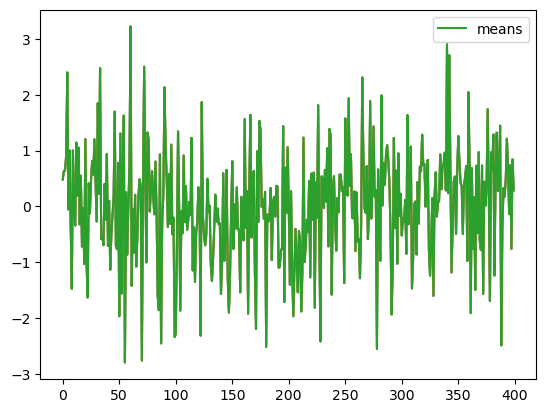

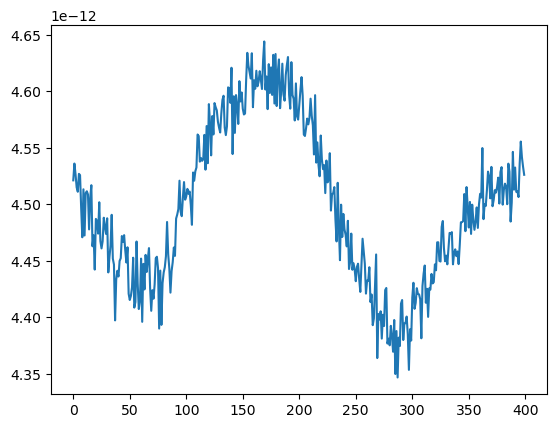

In [30]:
minimums = []
maximums = []
means = []
std = [] 
for i in range(400):
    minimums.append(np.min(phase_contrast[i]))
    maximums.append(np.max(phase_contrast[i]))
    means.append(np.mean(phase_contrast[i]))
    std.append(np.std(phase_contrast[i]))

plt.plot(minimums)
plt.plot(maximums)
plt.plot(means, label='means')
plt.legend()
plt.show()
plt.plot(std)

In [53]:
phase_contrast_subtracted = phase_contrast - np.array(means)[:,None,None]

In [54]:
phase_contrast_subtracted -= np.min(phase_contrast_subtracted)
phase_contrast_subtracted *= 1e12

In [55]:
phase_contrast_subtracted /= phase_contrast_subtracted.max() 
phase_contrast_subtracted *= 6e4

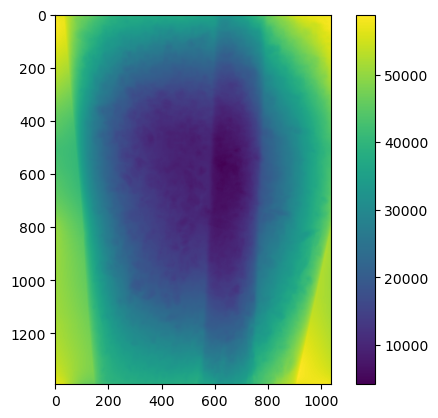

In [56]:
plt.imshow(phase_contrast_subtracted[120])
plt.colorbar()

Save as tiff

In [57]:
io.imsave('2023-03-22 phase_contrast.tiff', ( phase_contrast_subtracted).astype('uint16') )